# Train YOLOv2 on LISA Dataset
-----------------------------------------------


In [1]:
import sys
print(sys.version) # Check Python Version
import os
from keras.optimizers import Adam
from cfg import *

2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using TensorFlow backend.


### Prepare LISA Dataset

In [2]:
import numpy as np
from utils.parse_input import load_data    # Data handler for LISA dataset

x_train, y_train = load_data('data/training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)            # Count number of classes in the dataset
print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))
print("\nLabel Sample: \n{}".format(y_train[0]))
print("\n\nRelative Anchors using K-mean clustering [K=5]\n {}".format(ANCHORS))

Number of ground truth boxes: 3672 boxes
Train: 3672 samples
Number of classes: 31

Label Sample: 
[1093.5 408.0 45.0 48.0 'doNotEnter']


Relative Anchors using K-mean clustering [K=5]
 [[ 0.0237179   0.03571576]
 [ 0.05957714  0.08738709]
 [ 0.08816277  0.1294925 ]
 [ 0.03283318  0.04838902]
 [ 0.04450034  0.06430861]]


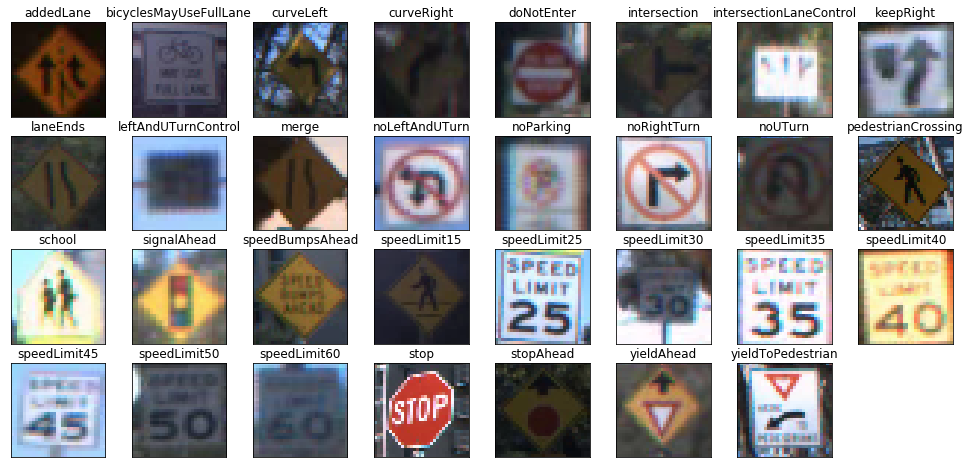

In [3]:
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

def extract_sign(img, bbox, output_size=(32, 32)):
    xc, yc, w, h = bbox.x, bbox.y, bbox.w, bbox.h
    x1   = int(xc - w/2)
    y1   = int(yc - h/2)
    x2   = int(xc + w/2)
    y2   = int(yc + h/2)
    roi = img[y1:y2, x1:x2]
    roi = cv2.resize(roi, output_size)
    return roi

x_train, y_train = shuffle(x_train, y_train)
fig = plt.figure(figsize=(17, 8))
for i, label in enumerate(labels):
    ax           = fig.add_subplot(4, 8, 1 + i, xticks=[], yticks=[])
    idx          = np.where(y_train[:, 1] == label)[0][0]
    img          = cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB)
    box          = y_train[idx][0]
    sign_only    = extract_sign(img, box, (32, 32)) #  just extract the sign
    ax.set_title(label)
    plt.imshow(sign_only)
plt.show()

### Construct YOLOv2 On Keras

In [4]:
from model.yolov2 import YOLOv2, darknet19
import keras.backend as K

K.clear_session() # Avoid duplicate model
pretrained_path = "/home/ubuntu/dataset/darknet19_544.weights"

darknet19 = darknet19(pretrained_path, freeze_layers=True)
yolov2    = YOLOv2(feature_extractor=darknet19, num_anchors=len(ANCHORS), num_classes=N_CLASSES)
model     = yolov2.model

Pre-trained weights have been loaded into model


## Loss Function

In [5]:
import keras.backend as K
import tensorflow as tf

def custom_loss(y_true, y_pred):
    """
    y_true: shape [BATCH, NUM_CLASSES + 5]
    y_pred: [BATCH, OUTPUT_W, OUTPUT_H, N_ANCHORS, N_CLASSES + 5]
    
    y_true provides: [xc, yc, w, h, conf, class_prob]
    y
    """
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    
    # Calculate IoU
    iou           = _calc_iou(true_boxes, pred_boxes)
    
    # Create detection mask
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    # Weight Terms
    weight_coor = 5.0 * tf.concat(4 * [true_conf], 4)
    weight_conf = 5.0 * true_conf   + 0.5 * (1. - true_conf)
    weight_prob = 5.0 * tf.concat(N_CLASSES * [true_conf], 4) 
    weight_terms = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    
        
    # Update wh --- > sqrt(wh)
    gt_boxes = tf.concat([true_boxes[..., :2], tf.sqrt(true_boxes[...,2:4])], 4)
    pred_boxes = tf.concat([pred_boxes[..., :2], tf.sqrt(pred_boxes[...,2:4])], 4)  

    y_true = tf.concat([gt_boxes, true_conf, true_cls], 4)
    y_pred = tf.concat([pred_boxes, pred_conf, pred_cls], 4)
        
    # Total loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight_terms
    loss = tf.reshape(loss, [-1,N_ANCHORS*(5+ N_CLASSES)* K.cast(pred_shape[0]*pred_shape[1], tf.int32)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

def _process_gt(y_true):
    """
    Process ground truth output
    """
    gt_shape = K.shape(y_true)
    y_true   = K.reshape(y_true, [gt_shape[0], gt_shape[1], gt_shape[2], N_ANCHORS, N_CLASSES + 5])
    true_boxes = y_true[...,:4]
    true_conf  = y_true[..., 4]
    true_clf   = y_true[...,5:]
    return true_boxes, true_conf, true_clf


def _process_prediction(y_pred):
    output_shape   = K.shape(y_pred)[1:3]
    OUTPUT_H = tf.cast(output_shape[0], tf.int32)
    OUTPUT_W = tf.cast(output_shape[1], tf.int32)
    
    # Scaled anchors to size of feature map
    scaled_anchors = ANCHORS*K.cast(K.reshape([OUTPUT_W, OUTPUT_H], [1, 1, 1, 1, 2]), tf.float32)
    anchor_tensor  = K.reshape(scaled_anchors, [1, 1, 1, N_ANCHORS, 2])
    y_pred         = K.reshape(y_pred, [-1, output_shape[0], output_shape[1], N_ANCHORS, N_CLASSES + 5])
    
    # Create offset map
    cx, cy = _create_offset_map(K.shape(y_pred))
    px     = tf.cast(anchor_tensor[...,0], dtype=tf.float32)
    py     = tf.cast(anchor_tensor[..., 1], dtype=tf.float32)
    
    # Calculate Prediction in relative position (percentage)    
    bx  = (tf.sigmoid(y_pred[..., 0]) + cx) / tf.cast(OUTPUT_W, tf.float32)
    by  = (tf.sigmoid(y_pred[..., 1]) + cy) / tf.cast(OUTPUT_H, tf.float32)
    bw  = px * tf.exp(y_pred[..., 2])       / tf.cast(OUTPUT_W, tf.float32)
    bh  = py * tf.exp(y_pred[..., 3])       / tf.cast(OUTPUT_H, tf.float32)
    
    # Extract features from prediction
    pred_boxes = tf.stack([bx, by, bw, bh], -1)
    pred_conf  = tf.sigmoid(y_pred[..., 4]) # to = sig
    pred_clf   = tf.nn.softmax(y_pred[..., 5:])

    return pred_boxes, pred_conf, pred_clf
    
                           
def _calc_iou(true_boxes, pred_boxes):
    # Scaled anchors to size of feature map
    output_shape   = K.shape(pred_boxes)[1:3]
    
    # Scale to input image
    GRID_SIZE =  K.cast(K.reshape([output_shape[1], output_shape[0]], [1, 1, 1, 1, 2]), tf.float32)
    
    pred_xy     = pred_boxes[...,:2]  * GRID_SIZE
    pred_wh     = pred_boxes[..., 2:4]* GRID_SIZE
    pred_area   = pred_wh[..., 0]     * pred_wh[..., 1]

    true_xy     = true_boxes[...,:2]  * GRID_SIZE
    true_wh     = true_boxes[...,2:4] * GRID_SIZE
    true_area   = true_wh[..., 0]     * true_wh[..., 1]
    
    # Calculate IoU between ground truth and prediction
    intersect_ul   = tf.maximum(pred_xy - 0.5*pred_wh, true_xy - 0.5*true_wh)
    intersect_br   = tf.minimum(pred_xy + 0.5*pred_wh, true_xy + 0.5*true_wh)
    intersect_wh   = tf.maximum(intersect_br - intersect_ul, 0.0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    iou = tf.truediv(intersect_area, true_area + pred_area - intersect_area)
    
    return iou

def _create_offset_map(output_shape):
    """
    In Yolo9000 paper, grid map
    """
    GRID_H    = tf.cast(output_shape[1], tf.int32)
    GRID_W    = tf.cast(output_shape[2], tf.int32)
    N_ANCHORS = len(ANCHORS)

    cx = tf.cast((K.arange(0, stop=GRID_W)), dtype=tf.float32)
    cx = K.expand_dims(cx, -1)
    cx = K.tile(cx, (GRID_H, N_ANCHORS))
    cx = K.reshape(cx, [-1, GRID_H, GRID_W, N_ANCHORS])

    cy = K.cast((K.arange(0, stop=GRID_H)), dtype=tf.float32)
    cy = K.reshape(cy, [-1, 1])
    cy = K.tile(cy, [1, N_ANCHORS*GRID_W])  
    cy = K.reshape(cy, [-1])    
    cy = K.reshape(cy, [-1, GRID_H, GRID_W, N_ANCHORS])
    
    return cx, cy

In [6]:
def avg_iou(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    
    iou           = _calc_iou(true_boxes, pred_boxes)
    true_conf     = tf.expand_dims(iou * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    return tf.reduce_sum(true_conf)

def coor(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    
    iou           = _calc_iou(true_boxes, pred_boxes)
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    # Update wh --- > sqrt(wh)
    gt_boxes   = tf.concat([true_boxes[..., :2], tf.sqrt(true_boxes[...,2:4])], 4)
    pred_boxes = tf.concat([pred_boxes[..., :2], tf.sqrt(pred_boxes[...,2:4])], 4)  

    weight_coor = 5.0 * tf.concat(4 * [true_conf], 4)
    coor_loss = tf.pow(pred_boxes - gt_boxes, 2) * weight_coor
    return tf.reduce_sum(coor_loss)

def obj(y_true, y_pred):
    pred_shape = K.shape(y_pred)[1:3]

    true_boxes, true_conf, true_cls = _process_gt(y_true)
    pred_boxes, pred_conf, pred_cls = _process_prediction(y_pred)
    iou           = _calc_iou(true_boxes, pred_boxes)
    
    best_box      = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box      = tf.to_float(best_box)
    true_conf     = tf.expand_dims(best_box * true_conf, -1)   # sigmoid(to) = P(object) * IoU
    pred_conf     = tf.expand_dims(pred_conf, -1)
    
    weight_conf = 5.0 * true_conf   + 0.5 * (1. - true_conf)
    obj_conf = tf.pow(pred_conf - true_conf, 2) * weight_conf
    
    return tf.reduce_sum(obj_conf)


In [ ]:
import os
import keras
from sklearn.model_selection import train_test_split

from utils.multi_gpu import make_parallel, get_gpus
from utils.data_generator import flow_from_list

# # HYPER-PARAMETERS
BATCH_SIZE = 8
EPOCHS     = 10
LEARN_RATE = 1e-5

# Data Generator
train_data_gen = flow_from_list(x_train, y_train, batch_size=BATCH_SIZE, augment_data=True)

# For Debugging purpose
tf_board   = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001, patience=3, mode='min', verbose=1)
save_model= keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: model.save_weights('/home/ubuntu/dataset/backup/yolov2-epoch%s-loss:%s.weights'%(epoch, str(logs.get('loss')))))

# Load pretrain weights
# model.load_weights("yolov2.weights")

# TRAIN ON MULTI-GPUS
n_gpus = get_gpus()
if n_gpus > 1:
    BATCH_SIZE = n_gpus * BATCH_SIZE
    model_par = make_parallel(model, n_gpus)
else:
    model_par = model

model_par.compile(optimizer=Adam(LEARN_RATE),loss=custom_loss, metrics=[avg_iou, coor, obj])
hist =  model_par.fit_generator(generator   = train_data_gen, 
                            steps_per_epoch = len(x_train)/BATCH_SIZE, 
                            epochs          = EPOCHS, 
                            callbacks       = [tf_board, early_stop, save_model],
                            workers=1, verbose=1)

model.save_weights('yolov2.weights')

There is(are) 1 GPU(s) on device.
Epoch 1/10
134/459 [=======>......................] - ETA: 892s - loss: 164.0055 - avg_iou: 7.2206 - coor: 1.3244 - obj: 2581.2423

## Multi-GPUs Training - Data Parallelism Approach

* Each GPU will have a copy of the model
* During training time, mean of all gradidents from each GPU will be calculated to update the model
<img style="width:40%" src="https://www.tensorflow.org/images/Parallelism.png">

In [ ]:
model.load_weights('yolov2.weights')

### Visualize training process using Tensorboard
Open `http://<public-dns>:6006`

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# samples, labels = train_data_gen.next()
# i = 2
# img    = samples[i]
# labels = labels.reshape([-1, 30, 40, 5, 36])
# box    = labels[i][8][30][0][:4]*np.array([1280, 960, 1280, 960])
# print(box)

# dot    = cv2.circle(img, (int(box[0]), int(box[1])), radius=5, color=[0, 1, 0], thickness=5)

# plt.figure(figsize=(10, 10))
# plt.imshow(dot)

In [ ]:
import tensorflow as tf 

class BoundBox:
    def __init__(self, class_num):
        self.x, self.y, self.w, self.h, self.c = 0., 0., 0., 0., 0.
        self.probs = np.zeros((class_num,))
    def iou(self, box):
        intersection = self.intersect(box)
        union = self.w*self.h + box.w*box.h - intersection
        return intersection/union
        
    def intersect(self, box):
        width  = self.__overlap([self.x-self.w/2, self.x+self.w/2], [box.x-box.w/2, box.x+box.w/2])
        height = self.__overlap([self.y-self.h/2, self.y+self.h/2], [box.y-box.h/2, box.y+box.h/2])
        return width * height
        
    def __overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2,x4) - x1        

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1. / (1.  + np.exp(-x))

def interpret_netout(image, netout):
    img_shape = image.shape
    boxes = []
    GRID_W = img_shape[0] / 32
    GRID_H = img_shape[1] / 32

    netout = np.reshape(netout, [GRID_W, GRID_H, len(ANCHORS), N_CLASSES+5])
    
    # interpret the output by the network
    print(GRID_W, GRID_H)
    print(np.shape(netout))
    for row in range(GRID_W):
        for col in range(GRID_H):
            for b in range(len(ANCHORS)):
                box = BoundBox(N_CLASSES)

                # first 5 weights for x, y, w, h and confidence
                box.x, box.y, box.w, box.h, box.c = netout[row, col, b,:5]
                box.x = (col + sigmoid(box.x)) / GRID_W
                box.y = (row + sigmoid(box.y)) / GRID_H
                box.w = ANCHORS[b][0] * np.exp(box.w) / GRID_W
                box.h = ANCHORS[b][1] * np.exp(box.h) / GRID_H
                box.w = ANCHORS[b][0] * np.exp(box.w)
                box.h = ANCHORS[b][1] * np.exp(box.h)
                box.c = sigmoid(box.c)

                # last  weights for class probabilities
                classes = netout[row,col,b,5:]
                box.probs = softmax(classes) * box.c # P(obj|class) = P(obj)*softmax(P(classes))
                box.probs *= box.probs > THRESHOLD
                boxes.append(box)

    # suppress non-maximal boxes
    for c in range(N_CLASSES):
        sorted_indices = list(reversed(np.argsort([box.probs[c] for box in boxes])))

        for i in xrange(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].probs[c] == 0: 
                continue
            else:
                for j in xrange(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if boxes[index_i].iou(boxes[index_j]) >= 0.4:
                        boxes[index_j].probs[c] = 0

    # draw the boxes using a threshold
    for box in boxes:
        max_indx = np.argmax(box.probs)
        max_prob = box.probs[max_indx]
        if max_prob > THRESHOLD:
            xmin  = int((box.x - box.w/2)) * image.shape[1]
            xmax  = int((box.x + box.w/2)) * image.shape[1]
            ymin  = int((box.y - box.h/2)) * image.shape[0]
            ymax  = int((box.y + box.h/2)) * image.shape[0]
            print((xmin,ymin), (xmax,ymax))
            print(max_indx)
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax),np.random.randint(0, 255, [3]), 3)
            cv2.putText(image, LABELS[max_indx], (xmin, ymin - 12), 0, 1e-3 * image.shape[0], (0,255,0), 2)
    return image

In [ ]:
from utils.image_handler import preprocess_img

imgs, labels = load_data('data/training.txt')
LABELS           = np.unique(labels[:,1])
THRESHOLD = 0.2

img = cv2.cvtColor(cv2.imread('test_images/stop.jpg'), cv2.COLOR_BGR2RGB)
img = preprocess_img(img)
netout = model.predict(np.expand_dims(img, 0))
result = interpret_netout(img, netout[0])